In [2]:

# 10/31/24


In [3]:

# I will analyze store sale data. I will try to predict sales for each product.


In [4]:

import pandas as pd

import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas import DataFrame, Series

import numpy as np

from sklearn.linear_model import LinearRegression

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


In [5]:

# what does test data look like?

df_test = pd.read_csv('test.csv')

df_test

# Okay, so test data is for 2 weeks out from end of training data.


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [6]:

df = pd.read_csv('train.csv')


In [12]:

# This cell was ran only to separate the original train.csv into 2 smaller csv files,
# so I could upload them to github. I will not run this cell again.

# # make the first 1.5 million rows into df1
# # make the rest into df2

# df1 = df.iloc[:1500000]

# df2 = df.iloc[1500000:]

# # then save df1 as a new csv file called train1.csv
# # then save df2 as a new csv file called train2.csv

# df1.to_csv('train1.csv', index=False)

# df2.to_csv('train2.csv', index=False)



In [10]:
# then create df1 from train1.csv and df2 from train2.csv

df1 = pd.read_csv('train1.csv')
df2 = pd.read_csv('train2.csv')

# then combine train1.csv and train2.csv into a single df called df.

df = pd.concat([df1, df2])

In [11]:
df


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
1500883,3000883,2017-08-15,9,POULTRY,438.133,0
1500884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
1500885,3000885,2017-08-15,9,PRODUCE,2419.729,148
1500886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [7]:

# 3,000,888 rows in total
# dates from 2013 to 2017
# store numbers from 1 to 54
# 33 unique family values
# max sales = 124717. min sales = 0. 939130 of those are 0.

# what are the different family values in df?
df['family'].unique()

# only stores 25 and 36 were open on New Year's (36 only in 2014)


array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [8]:

# let me see the dtypes

# date is object. I will convert it to datetime
df['date'] = pd.to_datetime(df['date'])

df.dtypes


id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [9]:

# let me start small. I don't know if I will tackle this whole dataset ever, but let me at least
# get something going by trying a subset of the data.
# I'll look at sales for just family 1, which will be HARDWARE.
#  I want to group total sales across all store_nbr's. I will group by date and sum sales.

df_hardware = df[df['family'] == 'HARDWARE']
df_hardware_sales = df_hardware.groupby('date')['sales'].sum()
df_hardware_sales = df_hardware_sales.reset_index()
df_hardware_sales


,date,sales
0,2013-01-01,0.0
1,2013-01-02,46.0
2,2013-01-03,37.0
3,2013-01-04,57.0
4,2013-01-05,87.0
...,...,...
1679,2017-08-11,83.0
1680,2017-08-12,89.0
1681,2017-08-13,108.0
1682,2017-08-14,66.0


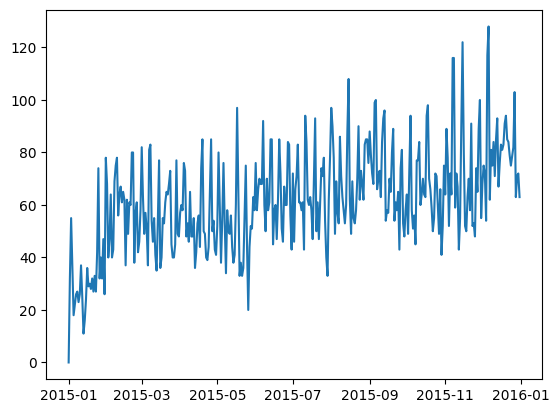

In [10]:

# let me plot just the year 2015 data of sales over time for hardware. Also date is in datetime format now.

df_hardware_sales_2015 = df_hardware_sales[df_hardware_sales['date'].dt.year == 2015]

plt.plot(df_hardware_sales_2015['date'], df_hardware_sales_2015['sales'])
plt.show()



In [ ]:

# Plot periodogram function.
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figsize to make the x-axis longer
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


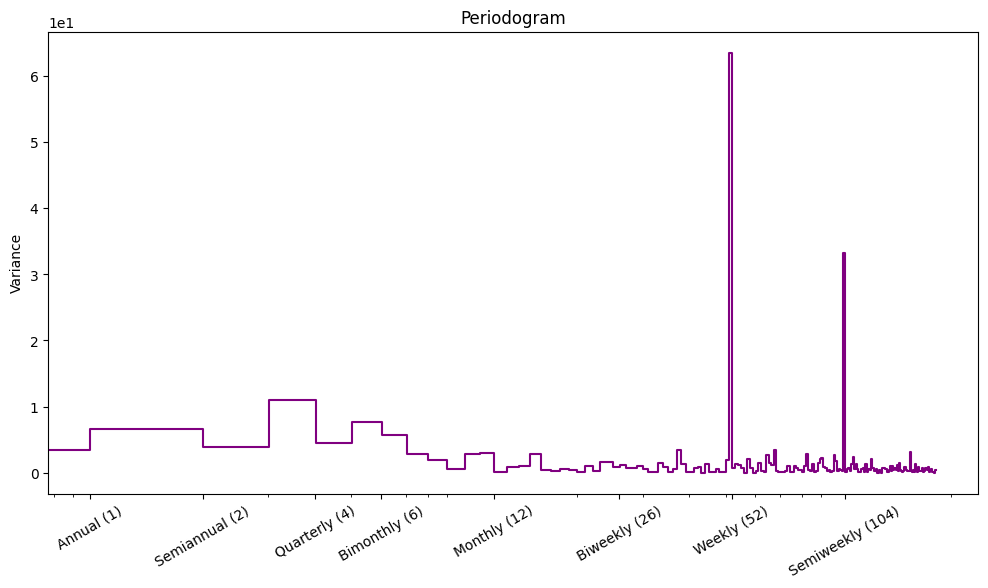

In [15]:

# i want to plot the periodogram for the hardware sales data
plot_periodogram(df_hardware_sales_2015['sales'])
plt.show()



In [18]:

# Given the periodogram, I think 12 Fourier pairs would be good. It goes all the way to monthly.

# Extract week of the year (1-52) and day of the week (0=Monday, 6=Sunday)
df_hardware_sales['week'] = df_hardware_sales['date'].dt.isocalendar().week  # ISO week of the year
df_hardware_sales['day'] = df_hardware_sales['date'].dt.weekday              # Day of the week (0=Monday, 6=Sunday)

# Display the DataFrame with new columns
df_hardware_sales


,date,sales,week,day
0,2013-01-01,0.0,1,1
1,2013-01-02,46.0,1,2
2,2013-01-03,37.0,1,3
3,2013-01-04,57.0,1,4
4,2013-01-05,87.0,1,5
...,...,...,...,...
1679,2017-08-11,83.0,32,4
1680,2017-08-12,89.0,32,5
1681,2017-08-13,108.0,32,6
1682,2017-08-14,66.0,33,0


In [29]:

# Convert 'date' column to datetime and set it as the index
df_hardware_sales['date'] = pd.to_datetime(df_hardware_sales['date'])
df_hardware_sales.set_index('date', inplace=True)


In [ ]:

# add fourier features
fourier = CalendarFourier(freq="A", order=12)  # 12 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=df_hardware_sales.index,
    # constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

df_hardware_sales = dp.in_sample()  # create features for dates in df_hardware_sales.index

df_hardware_sales


AssertionError: 

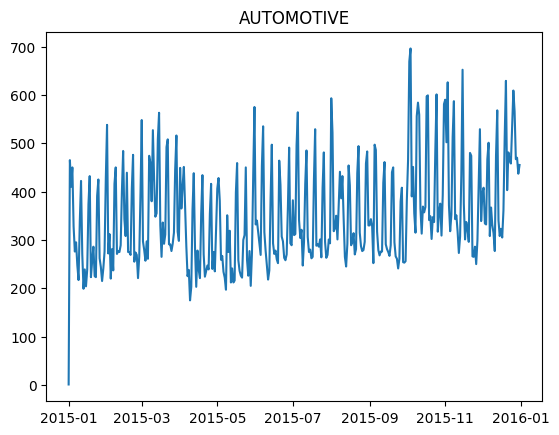

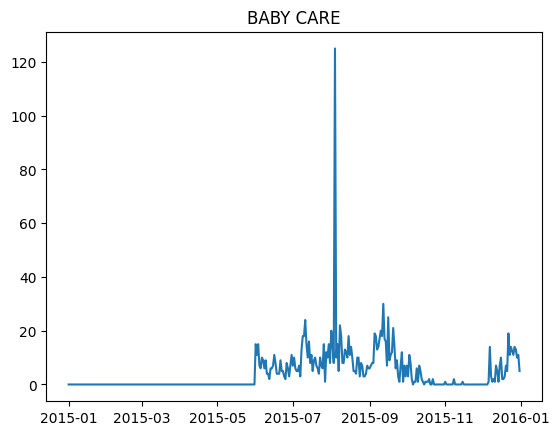

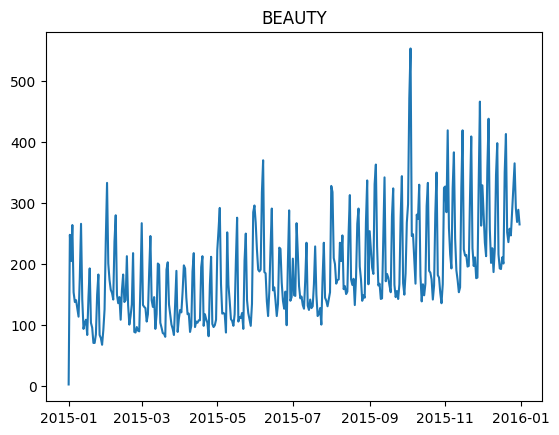

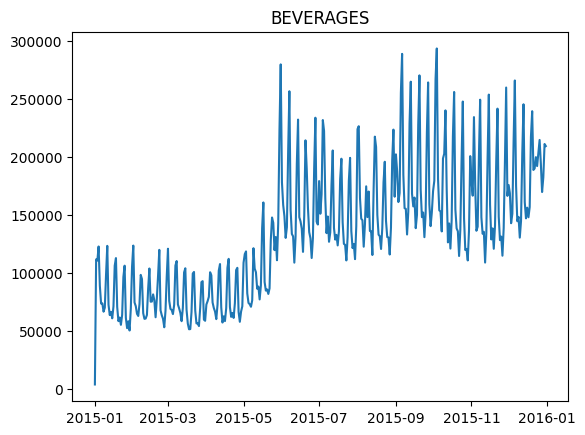

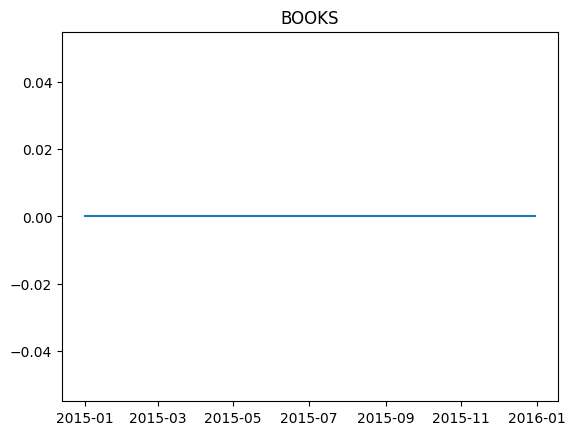

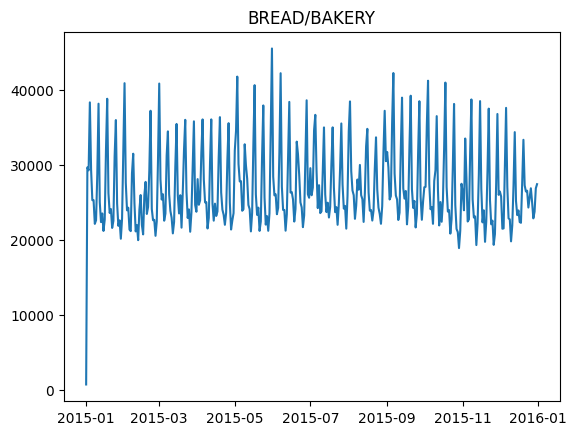

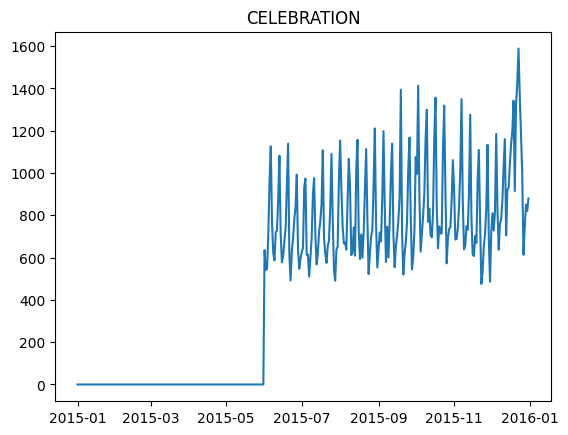

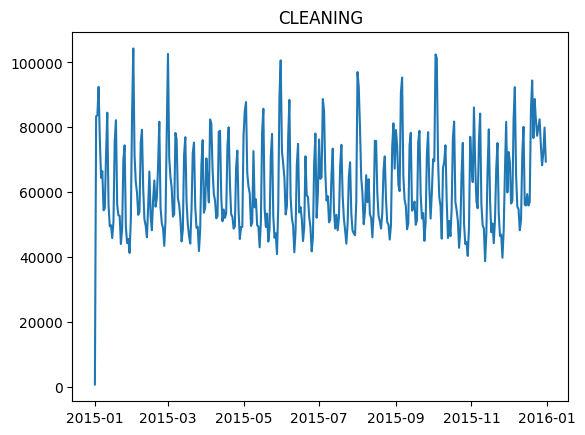

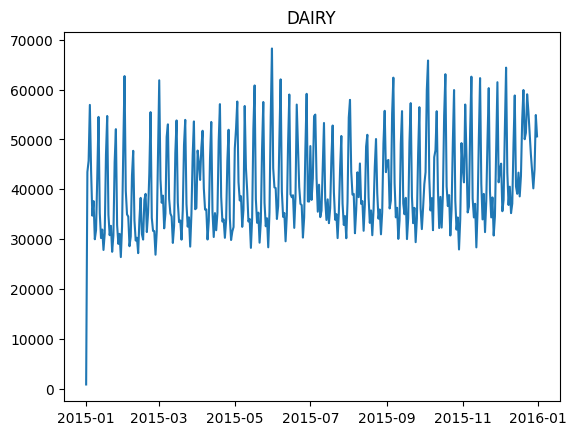

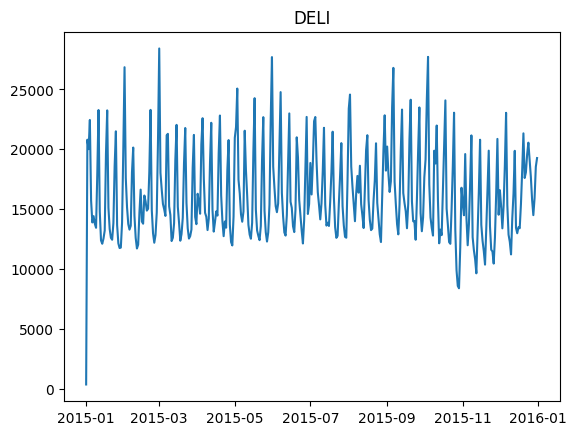

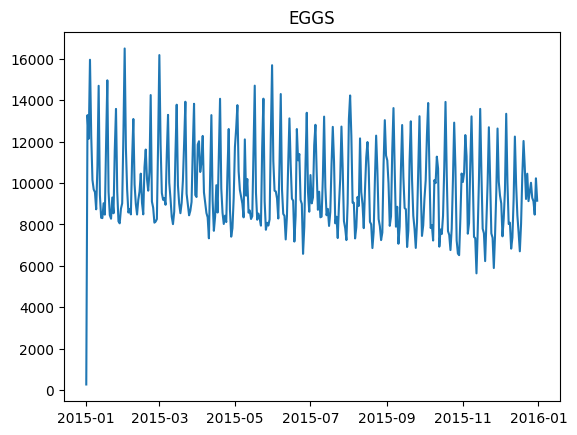

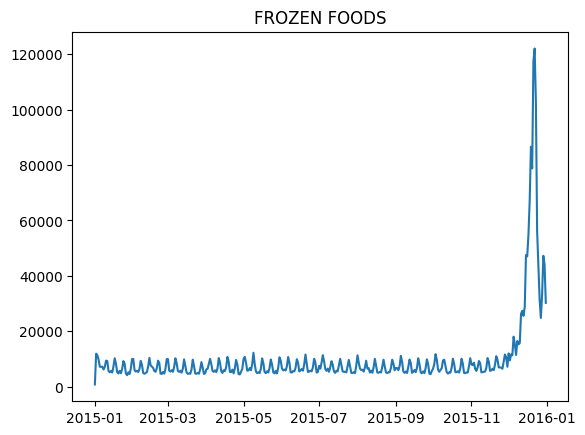

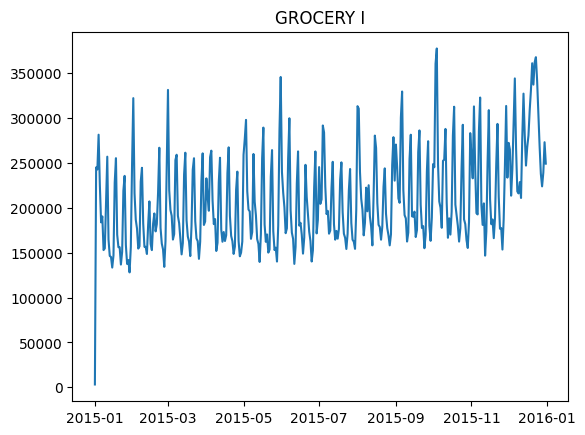

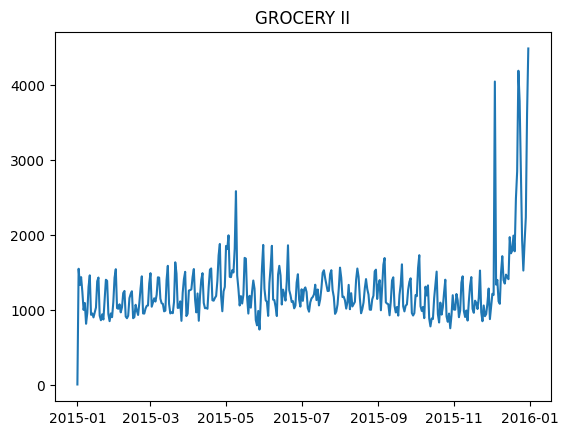

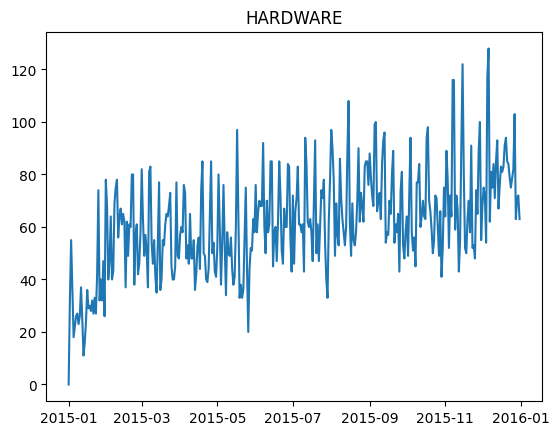

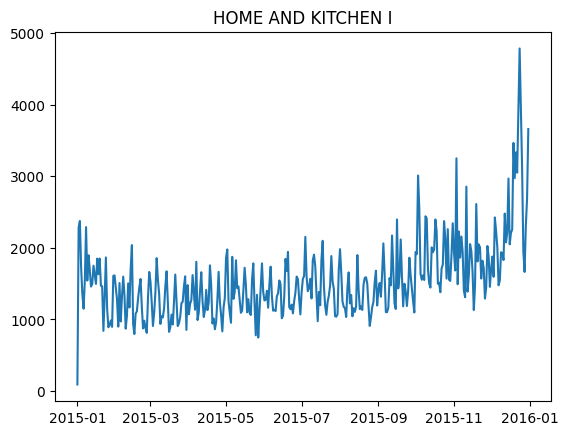

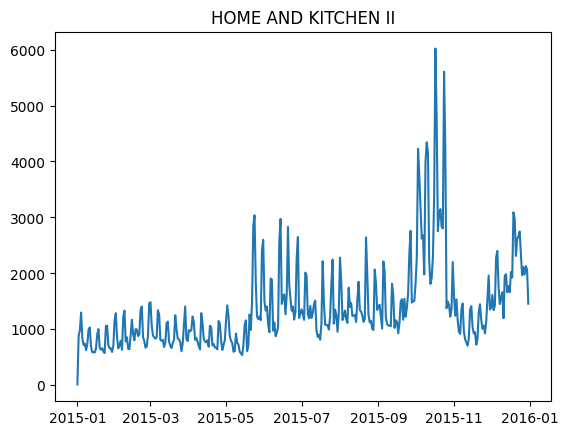

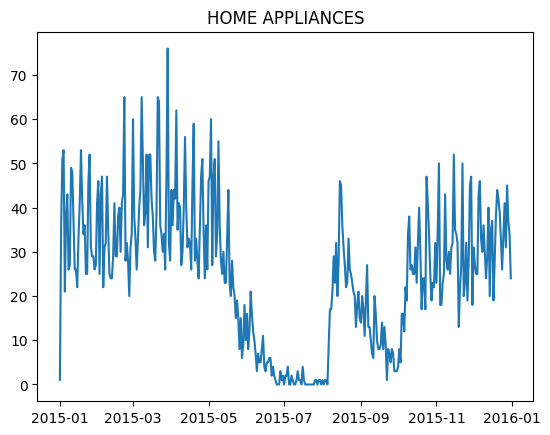

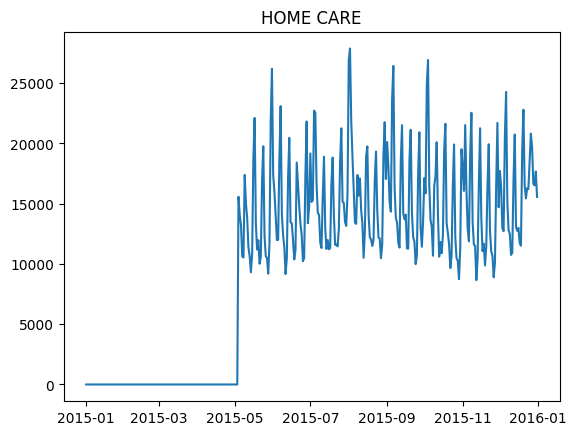

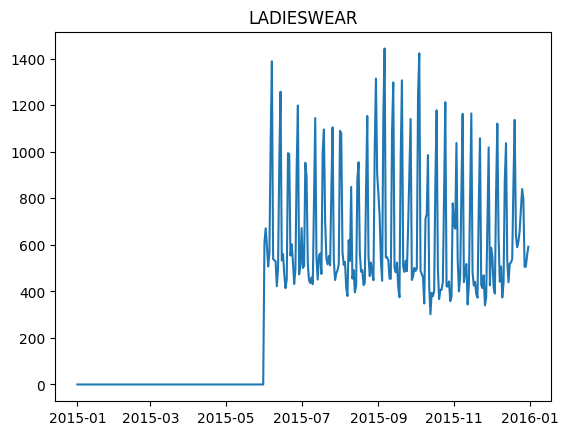

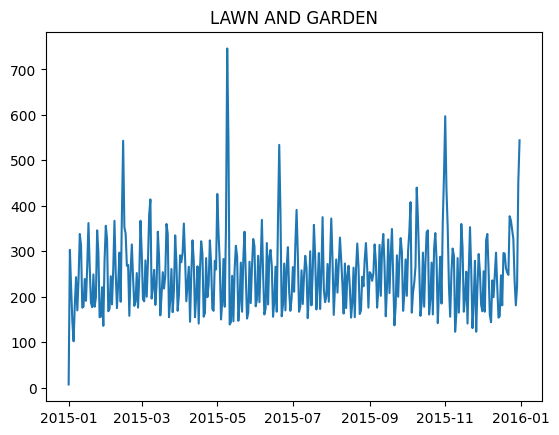

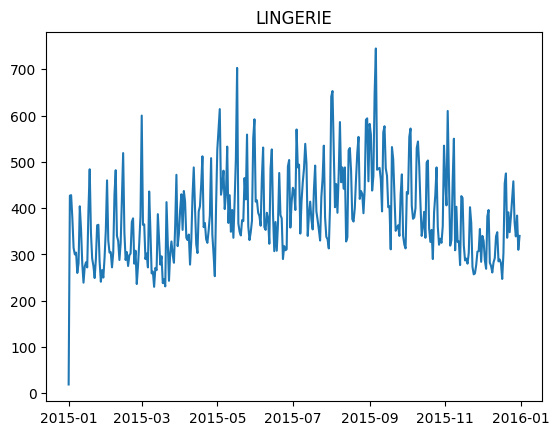

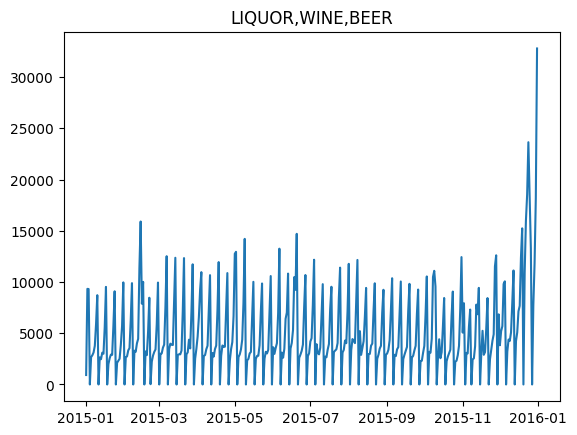

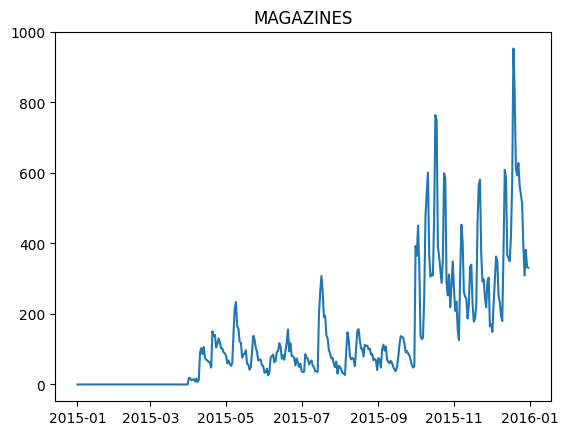

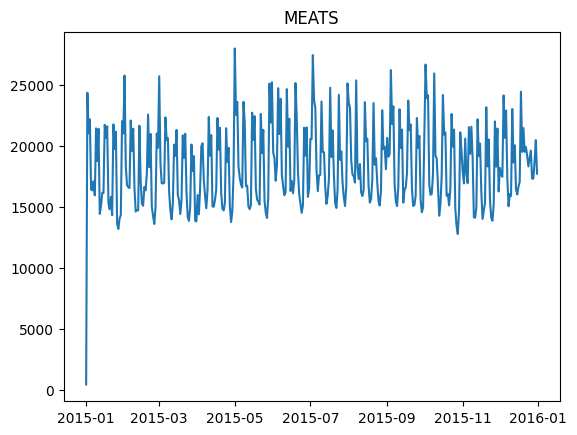

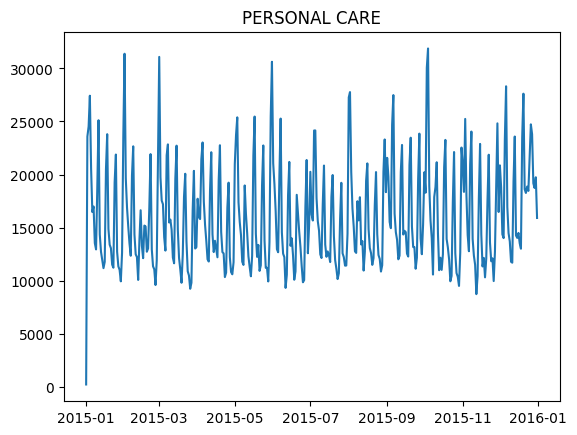

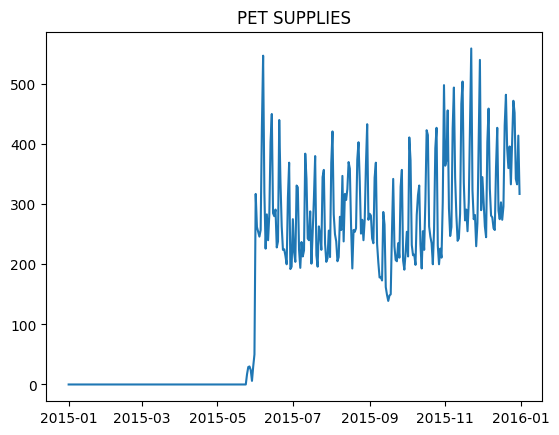

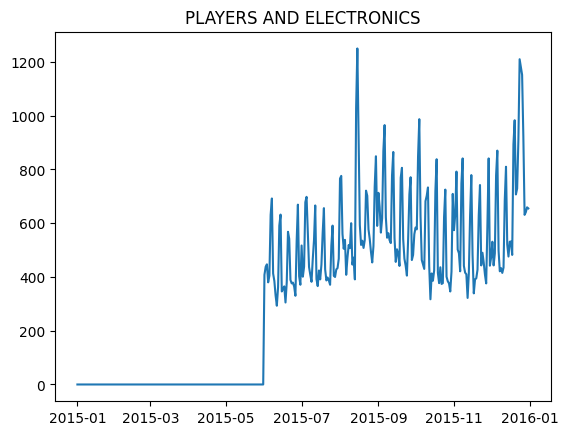

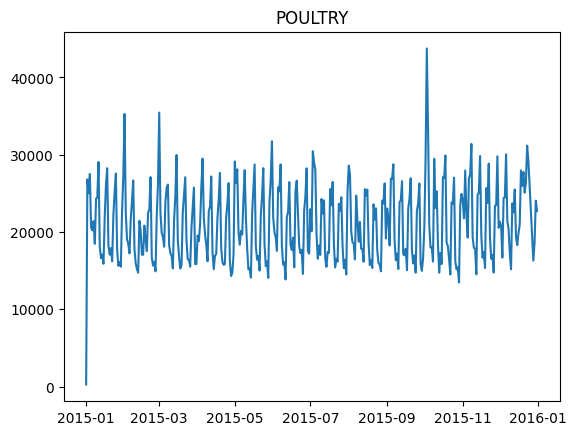

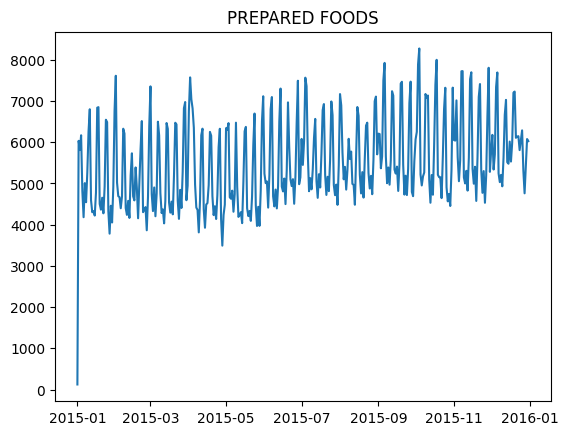

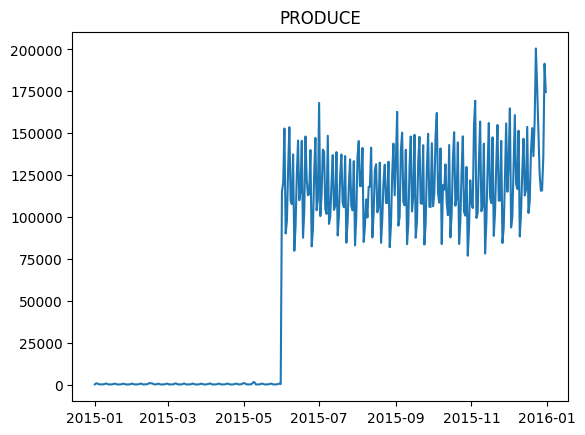

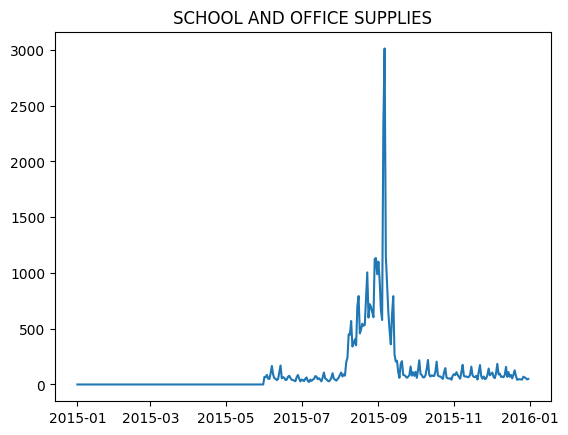

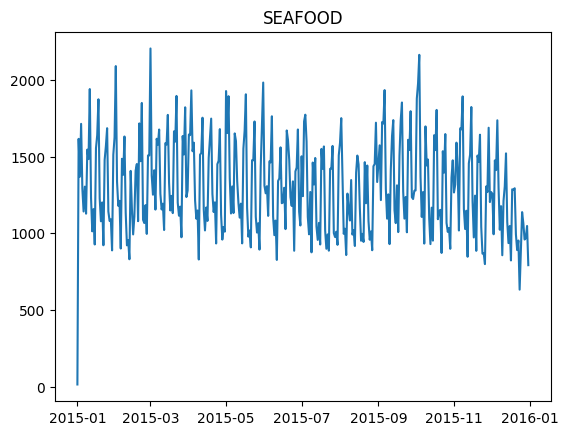

In [11]:

# okay so what i just did for hardware, i want to do for all the families.
# i will make a function to do this for me.

def get_family_sales(df, family):
    df_family = df[df['family'] == family]
    df_family_sales = df_family.groupby('date')['sales'].sum()
    df_family_sales = df_family_sales.reset_index()
    return df_family_sales

# now i will for loop through this function using the unique family values in df.

family_sales = {}

for family in df['family'].unique():
    family_sales[family] = get_family_sales(df, family)

# okay, now i have a dictionary of dataframes, where each dataframe is sales over time for each family.
# now i will plot each of these dataframes, using just thier 2015 data.

for family in family_sales:
    df_family_sales = family_sales[family]
    df_family_sales_2015 = df_family_sales[df_family_sales['date'].dt.year == 2015]
    plt.plot(df_family_sales_2015['date'], df_family_sales_2015['sales'])
    plt.title(family)
    plt.show()



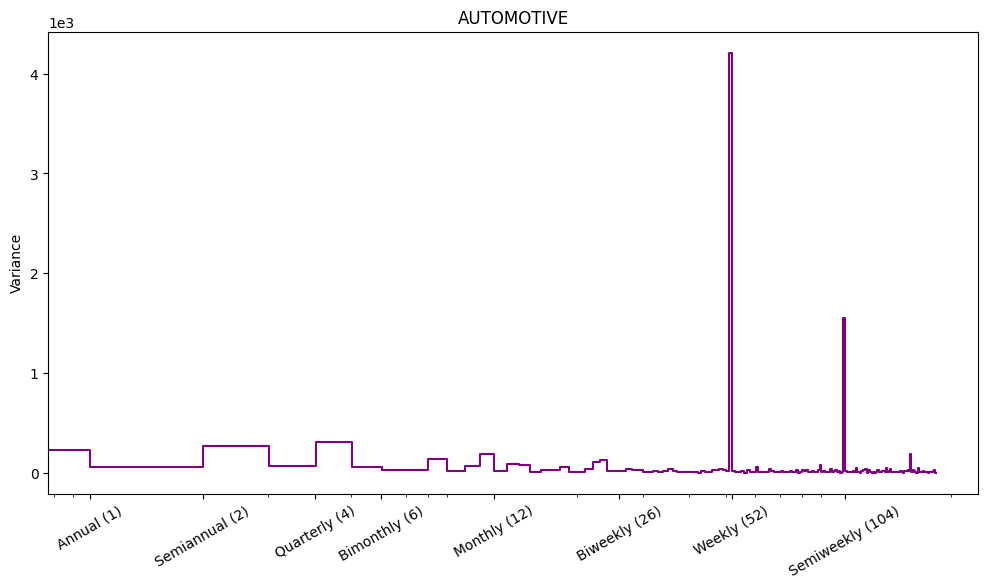

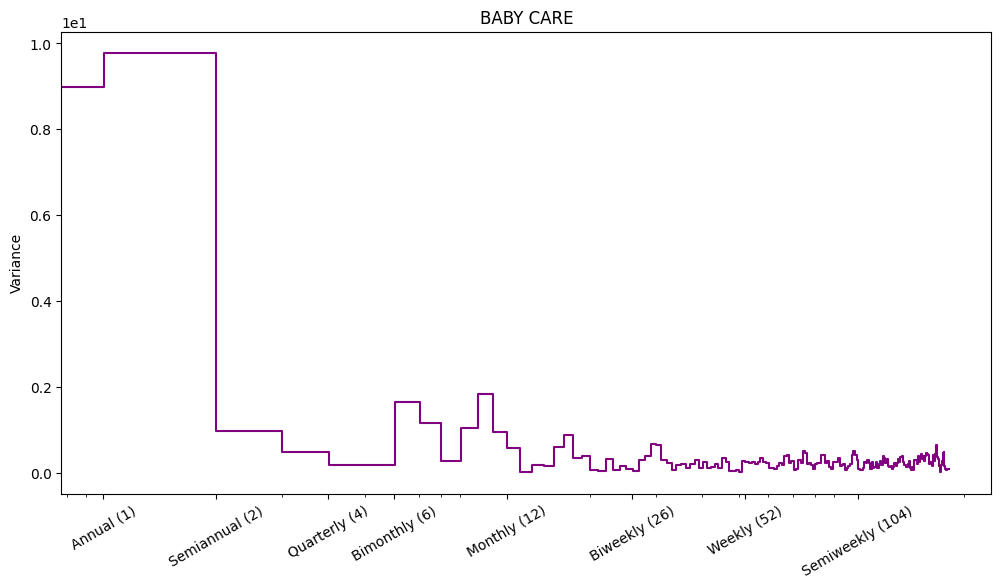

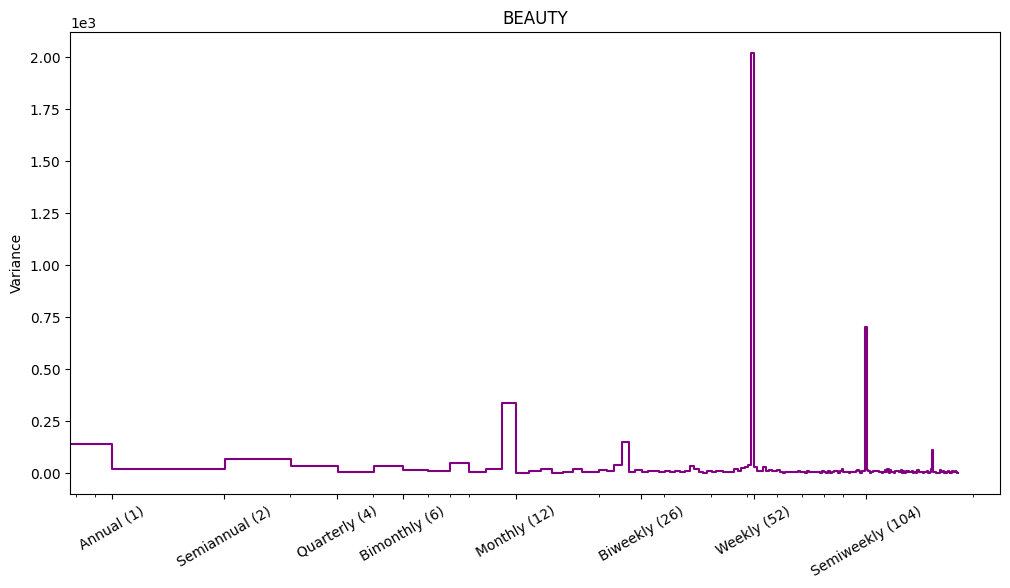

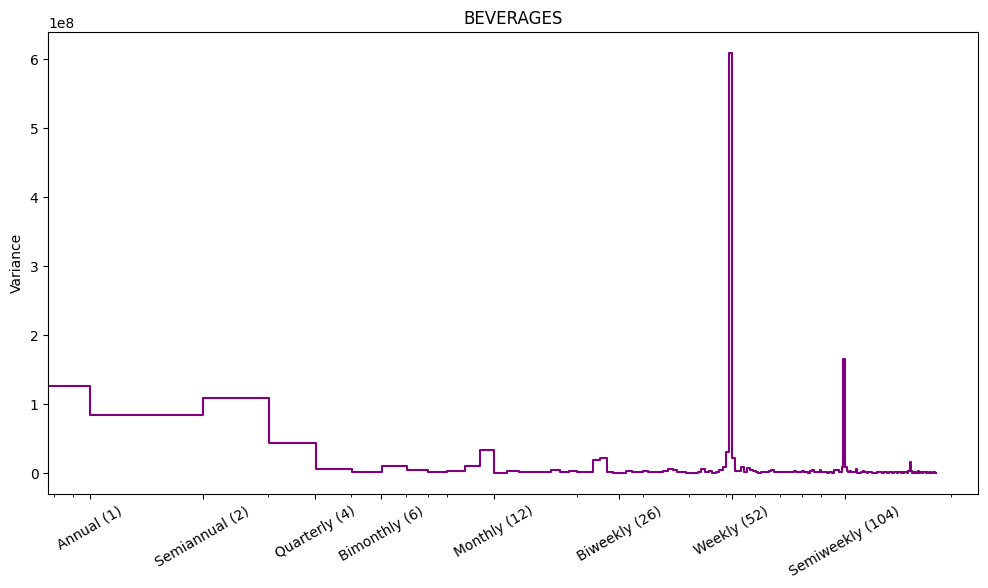

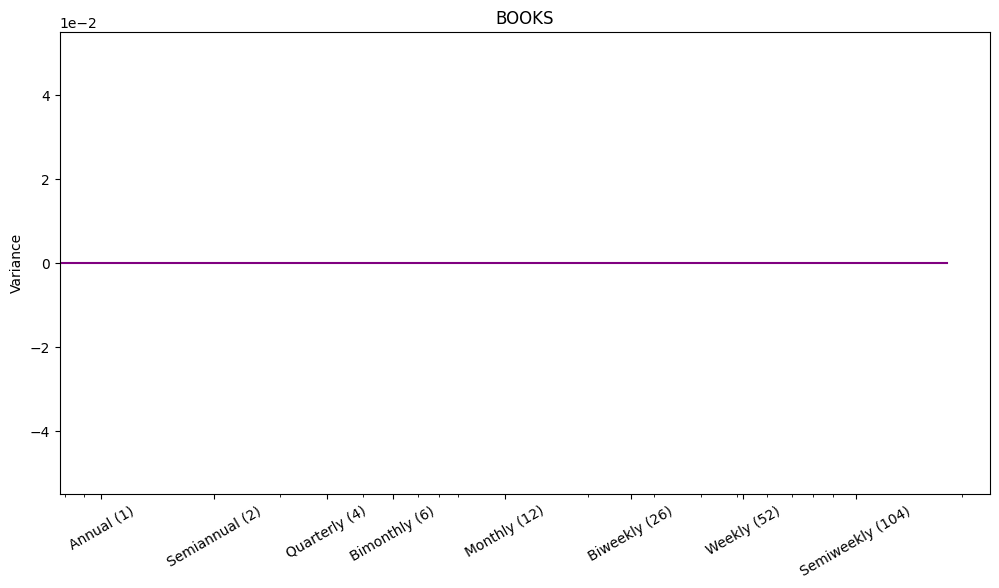

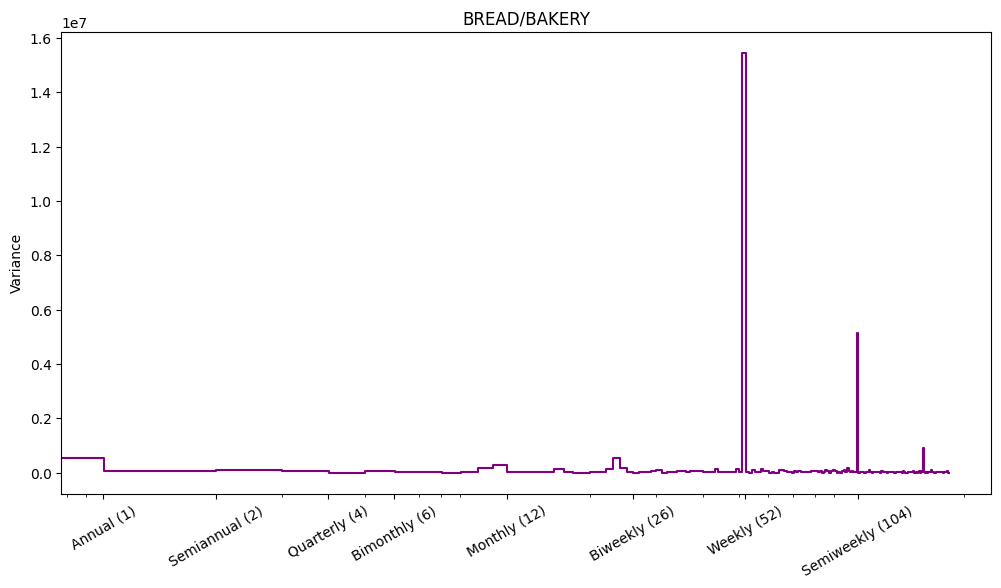

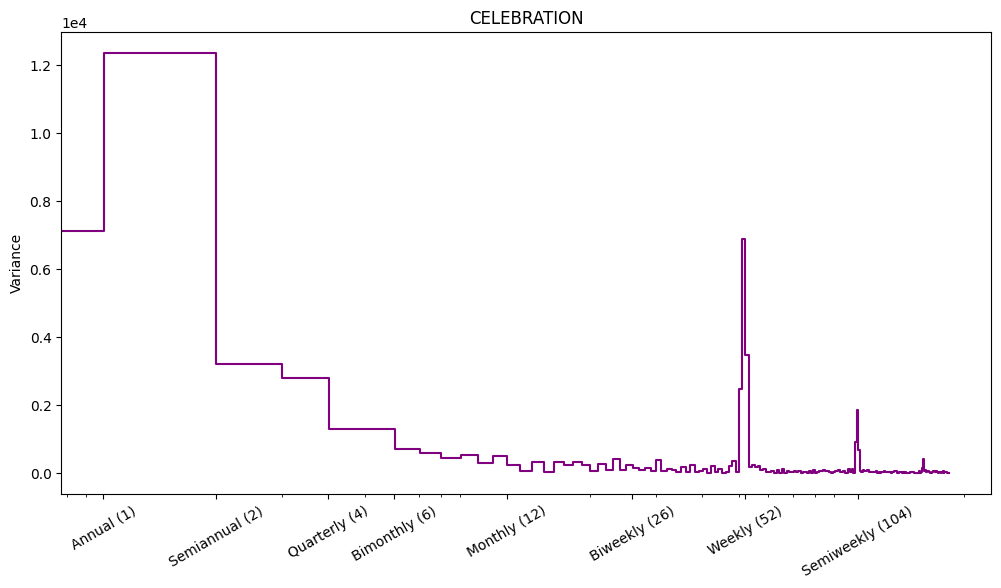

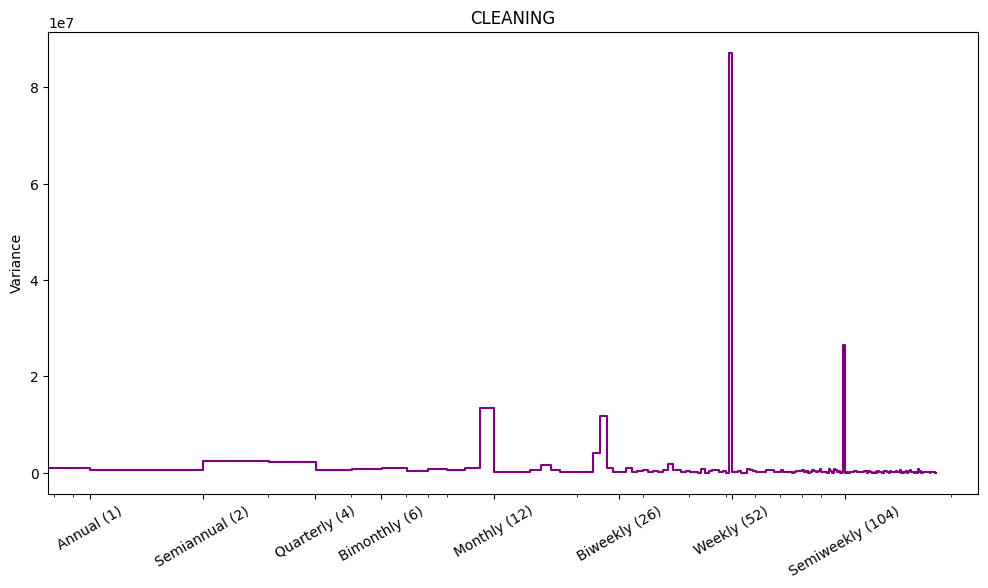

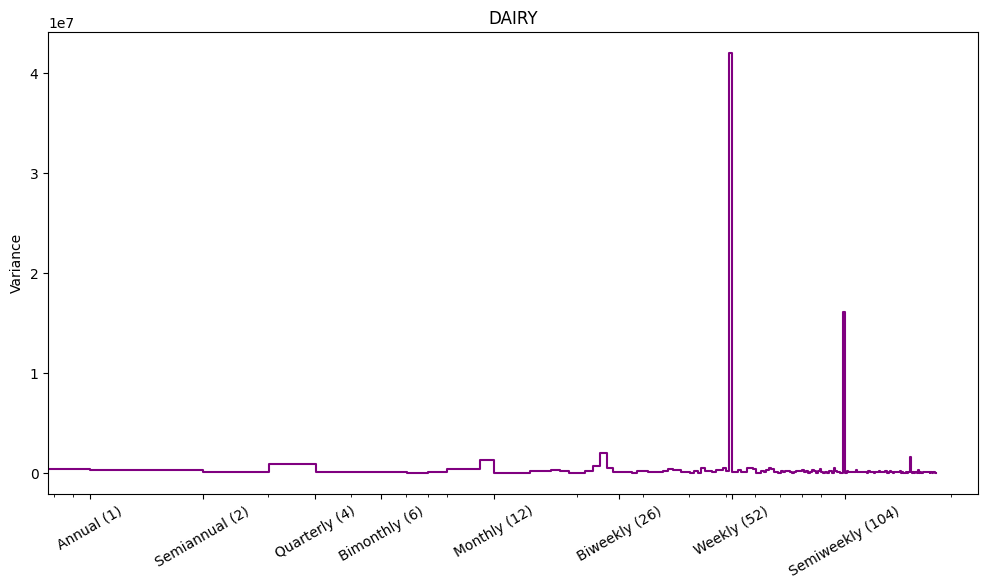

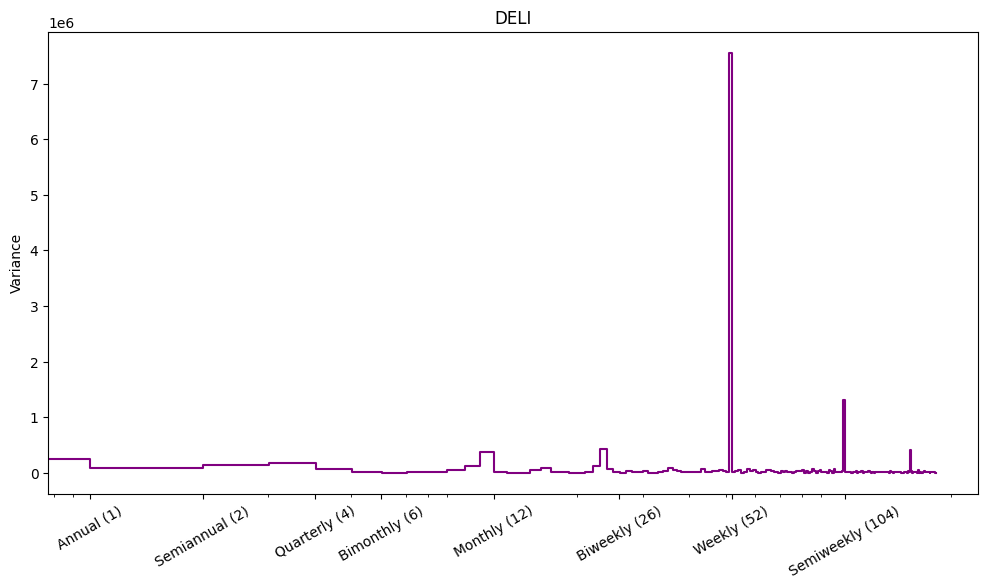

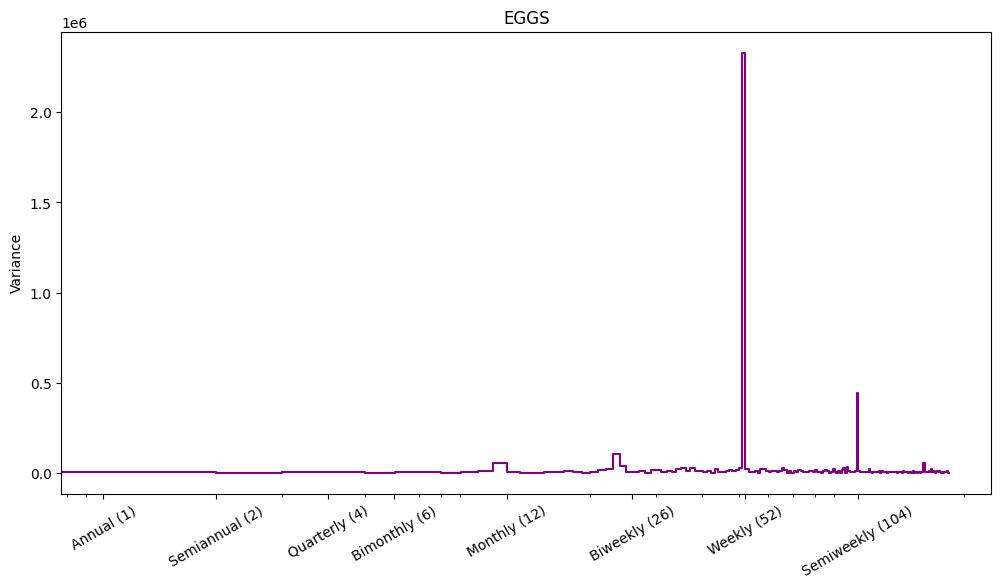

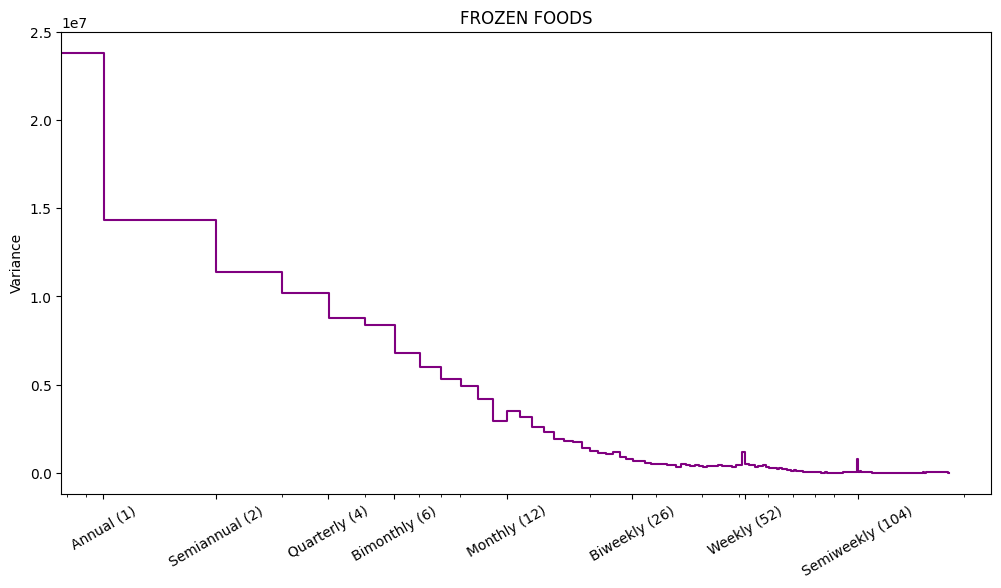

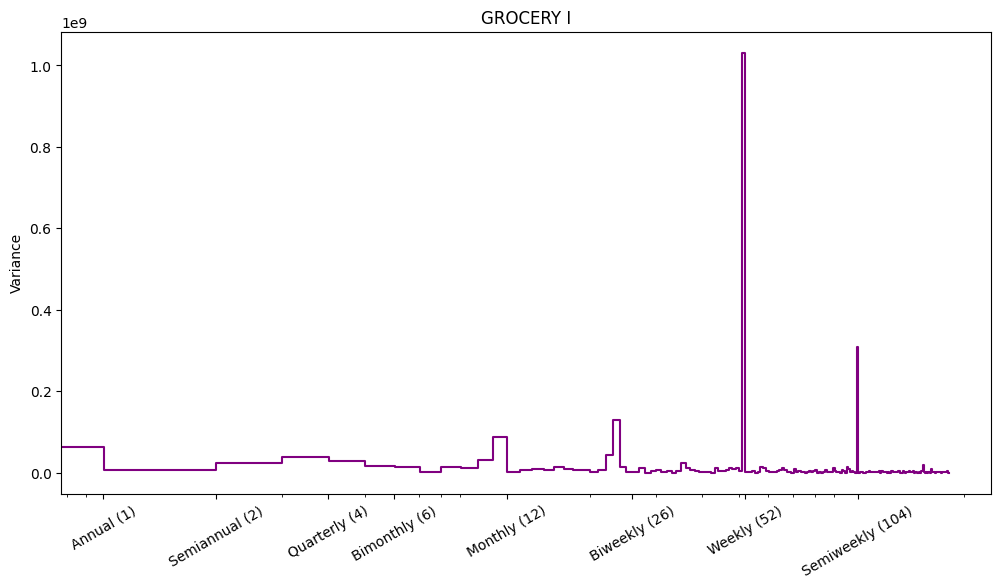

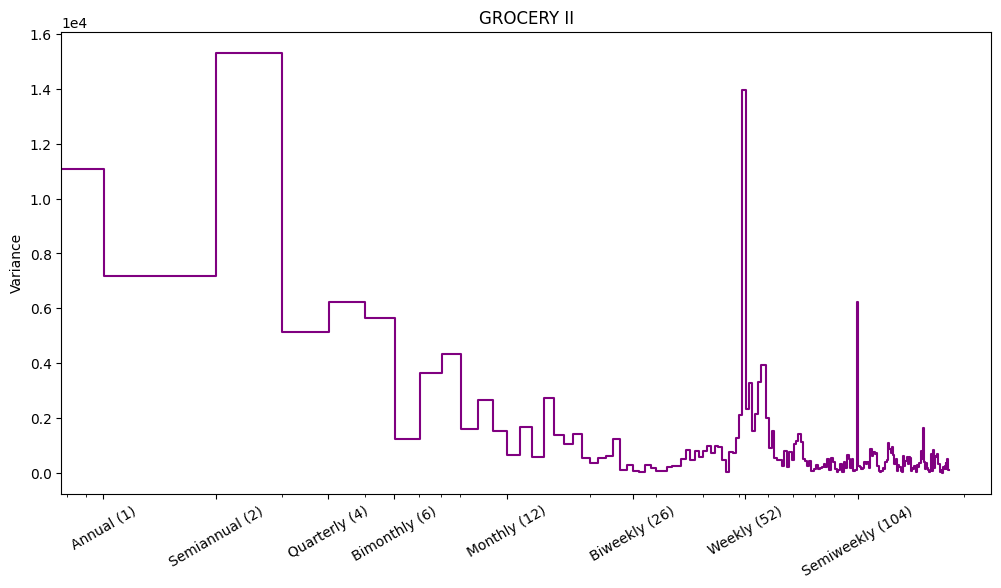

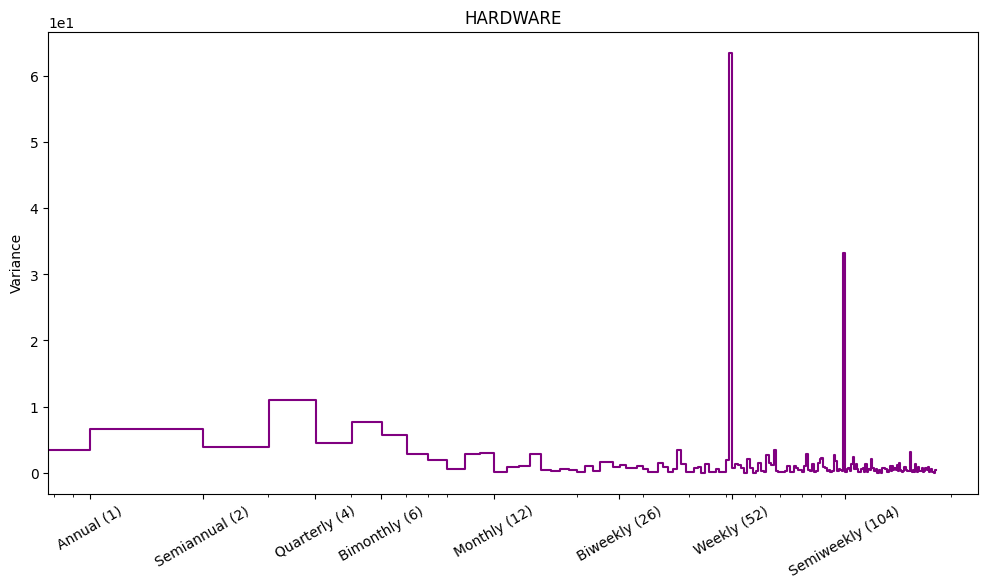

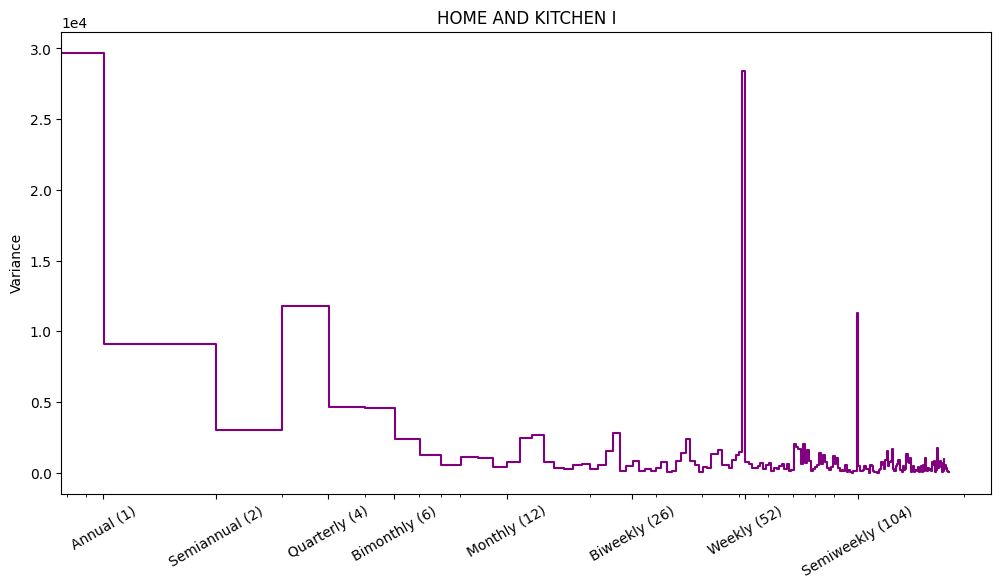

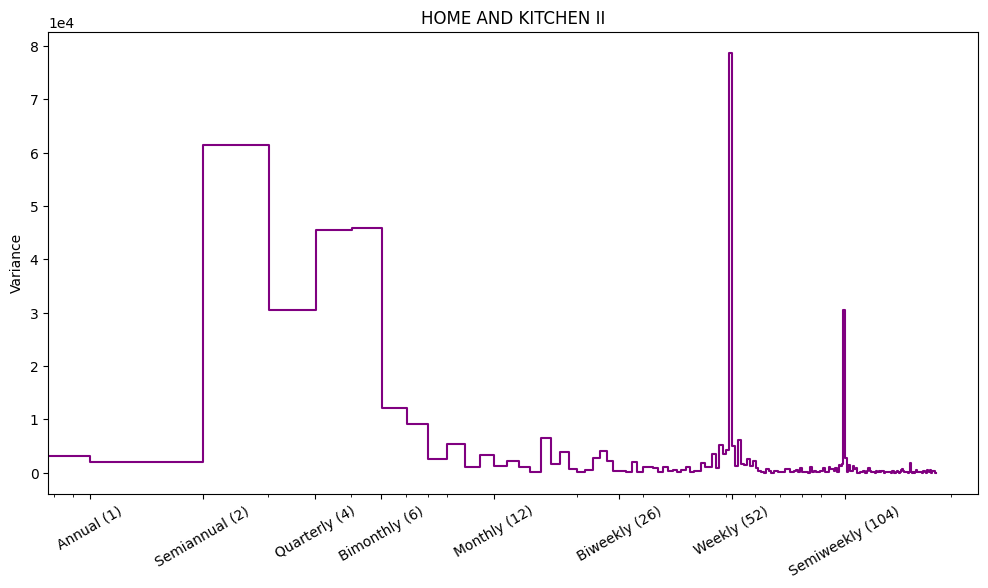

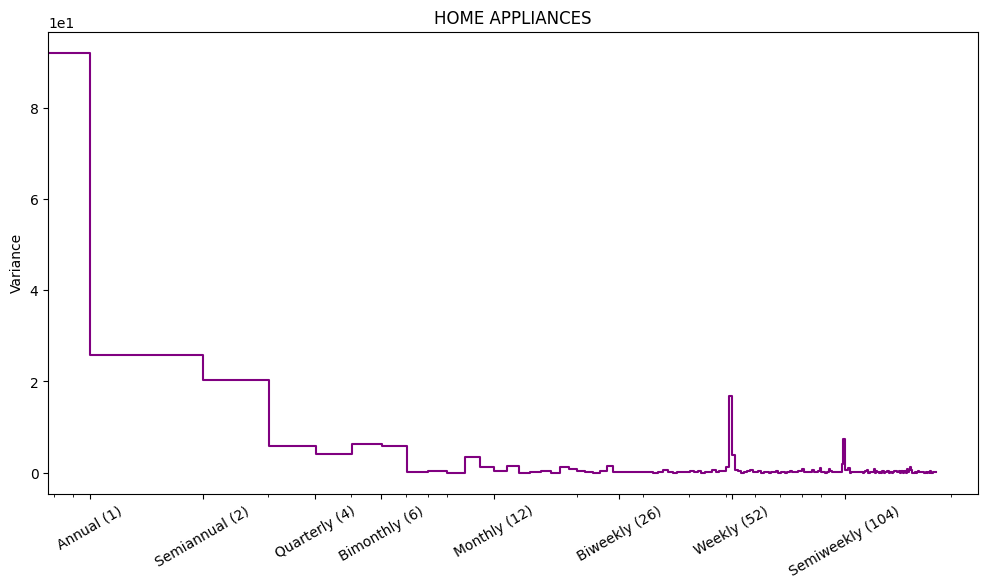

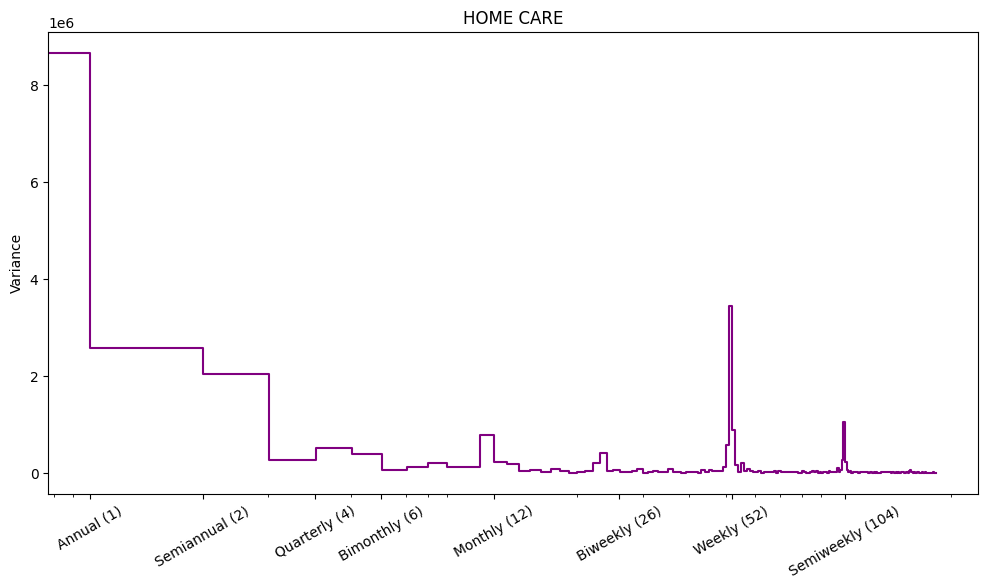

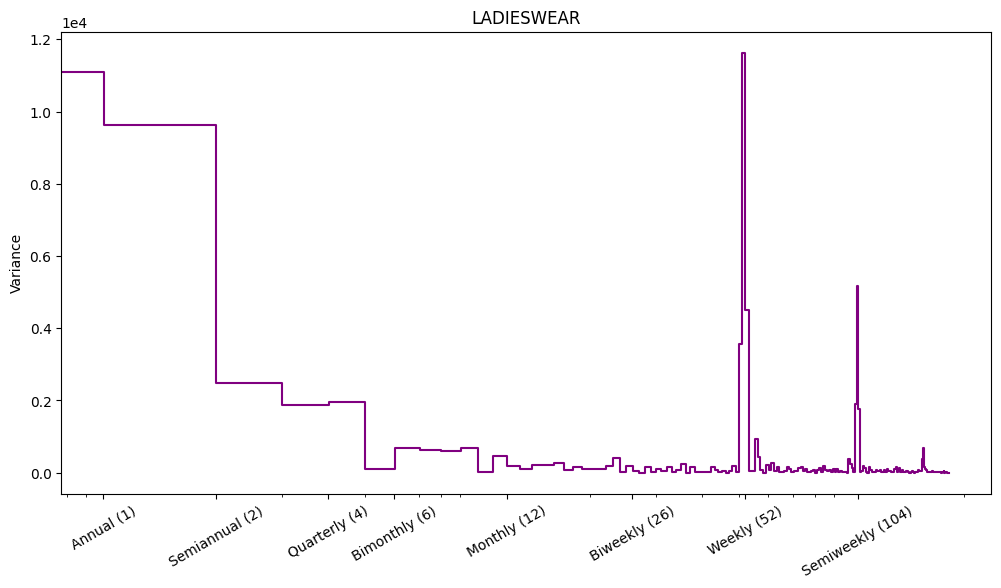

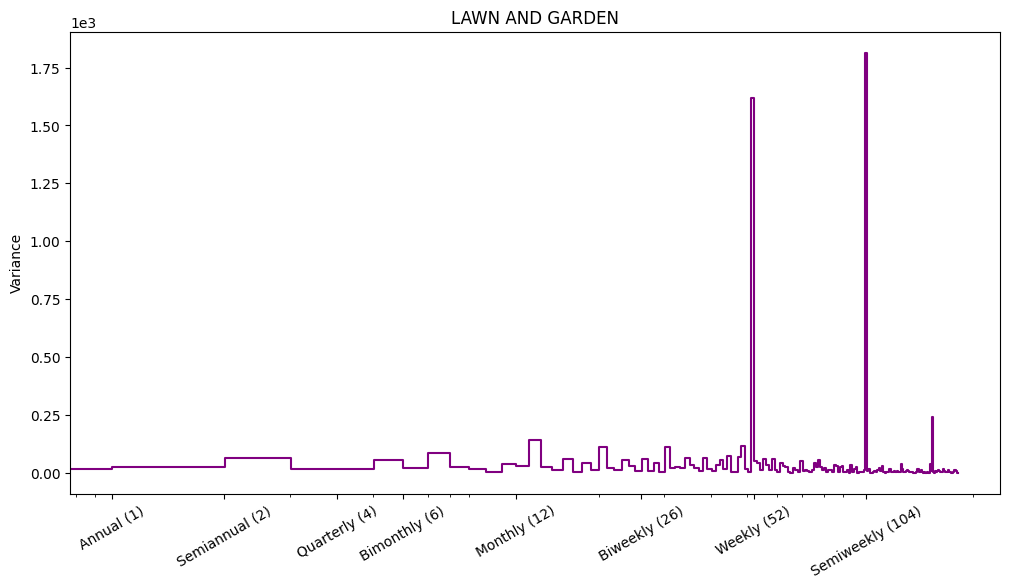

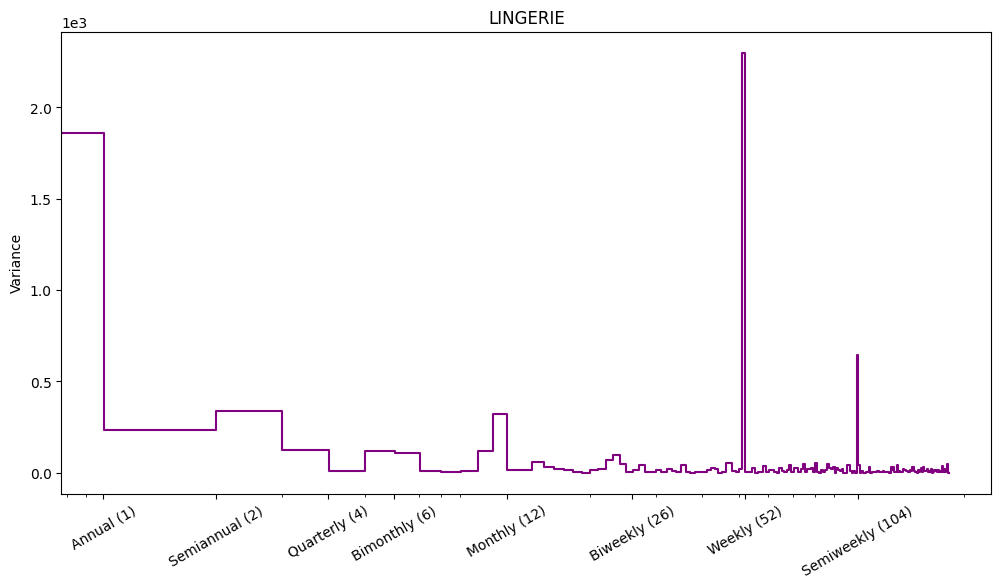

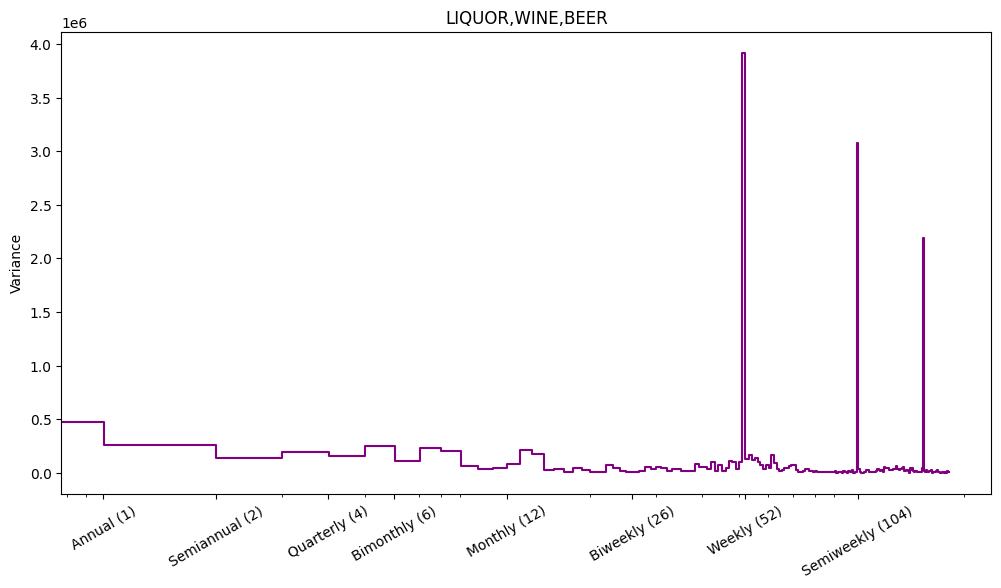

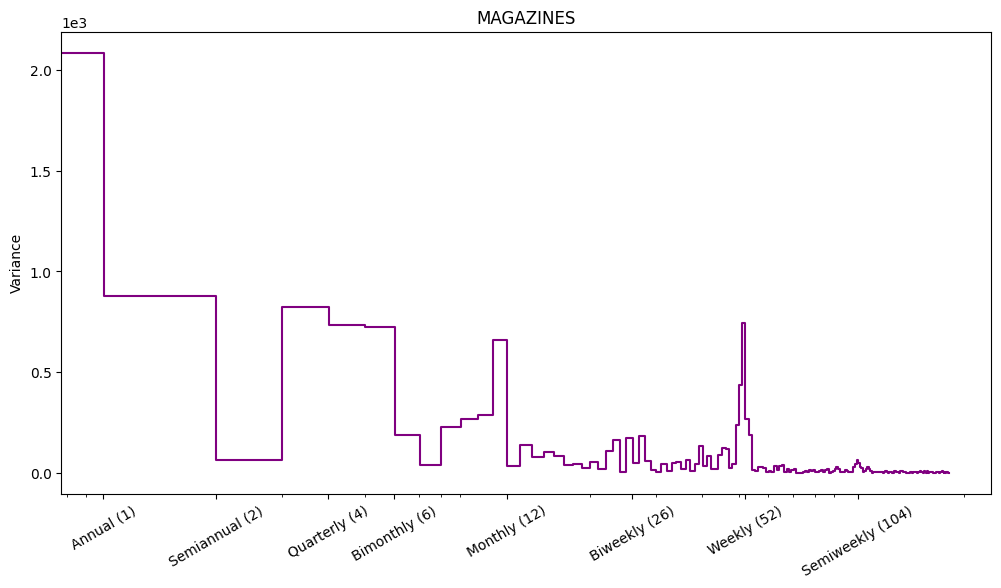

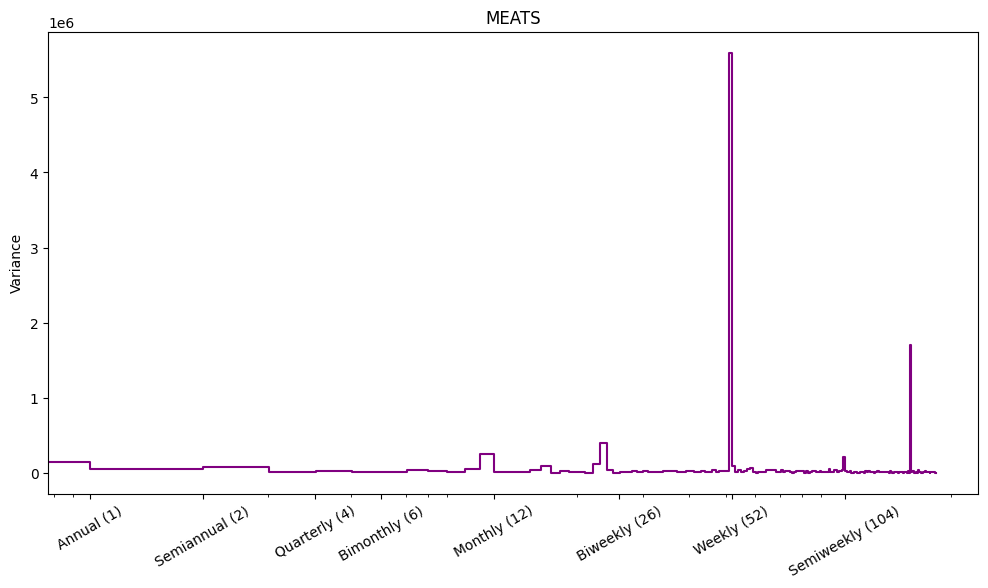

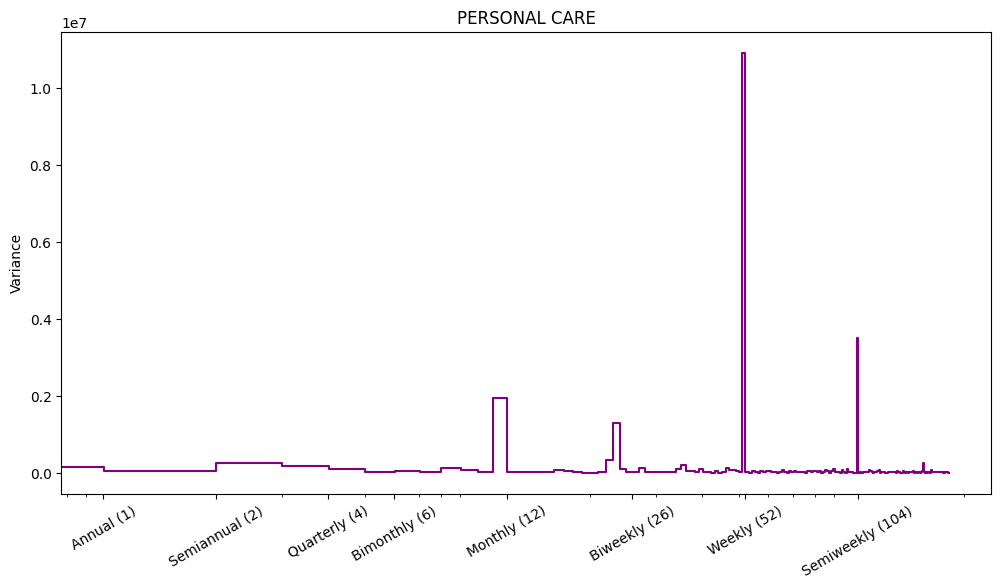

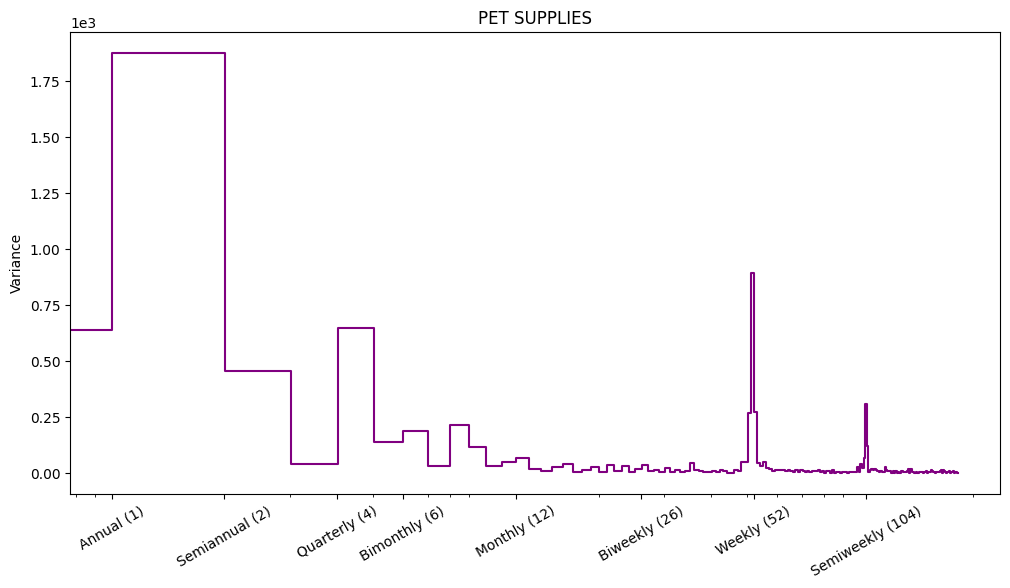

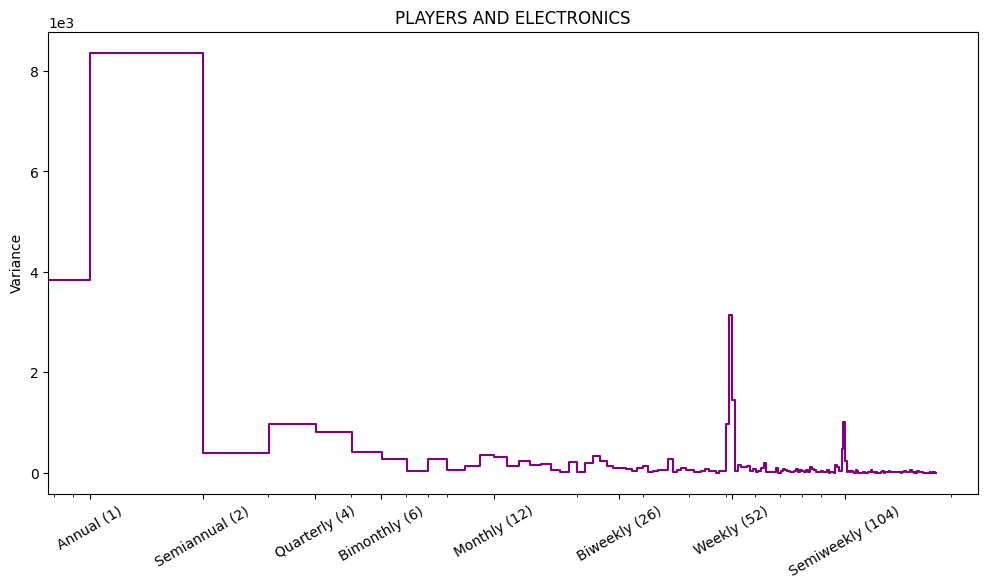

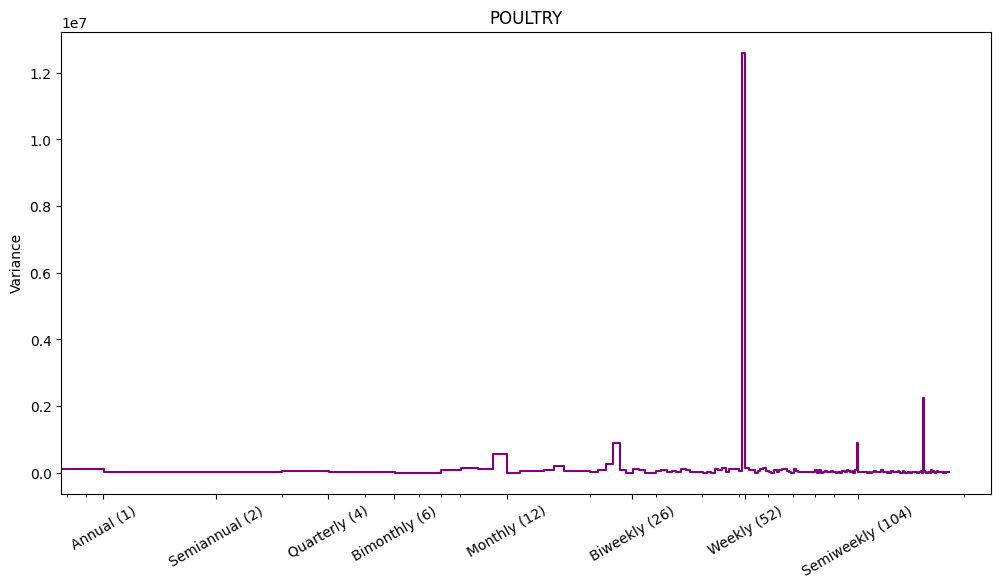

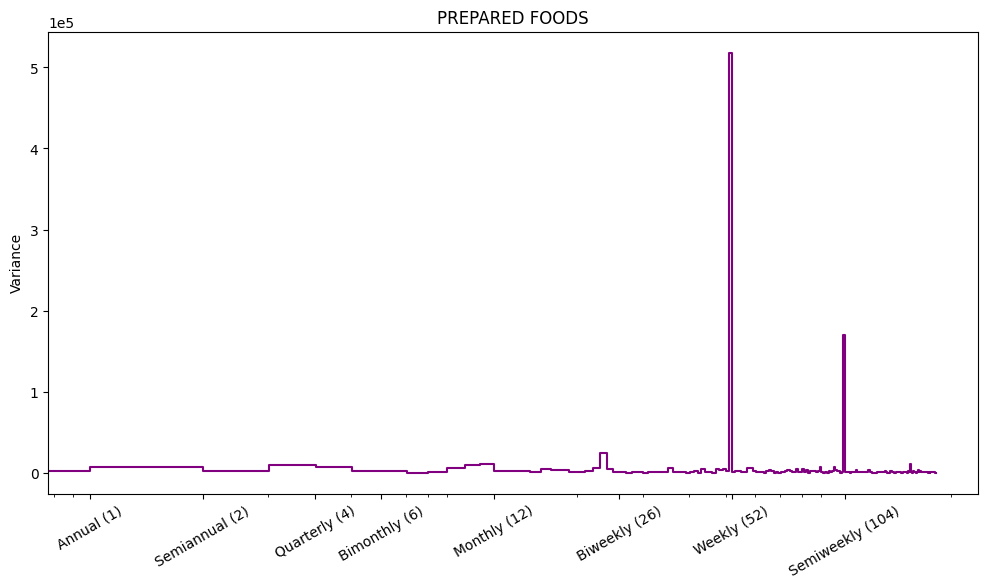

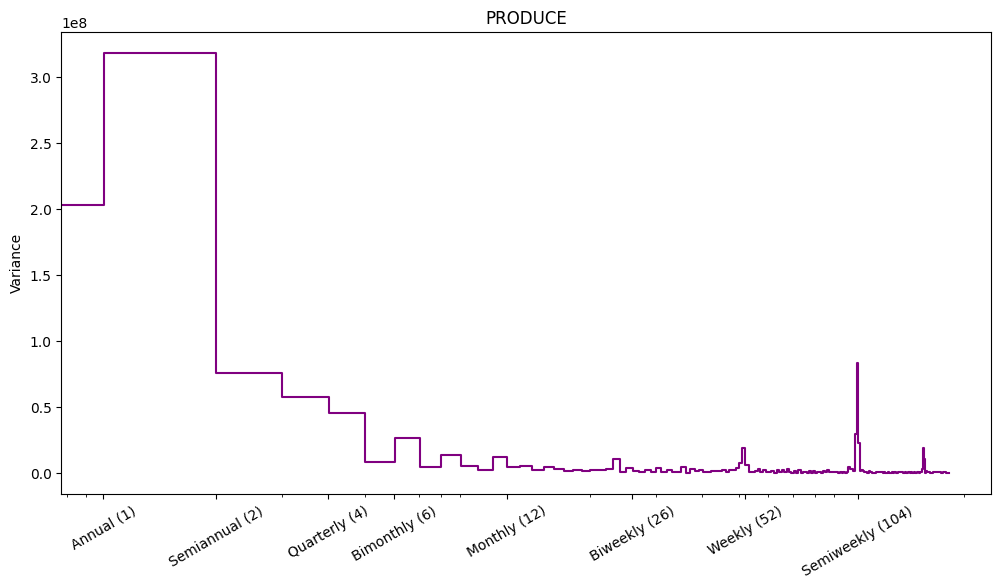

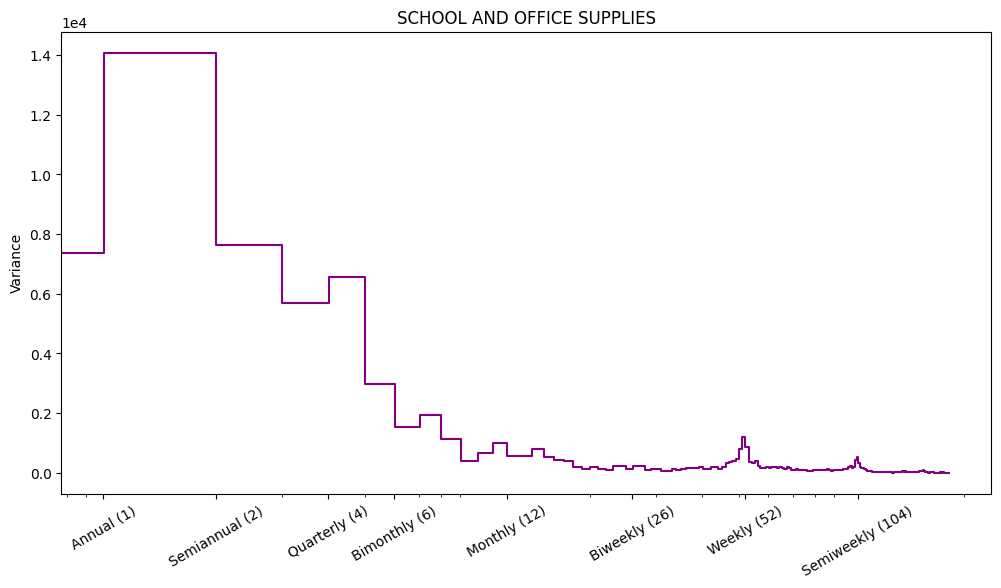

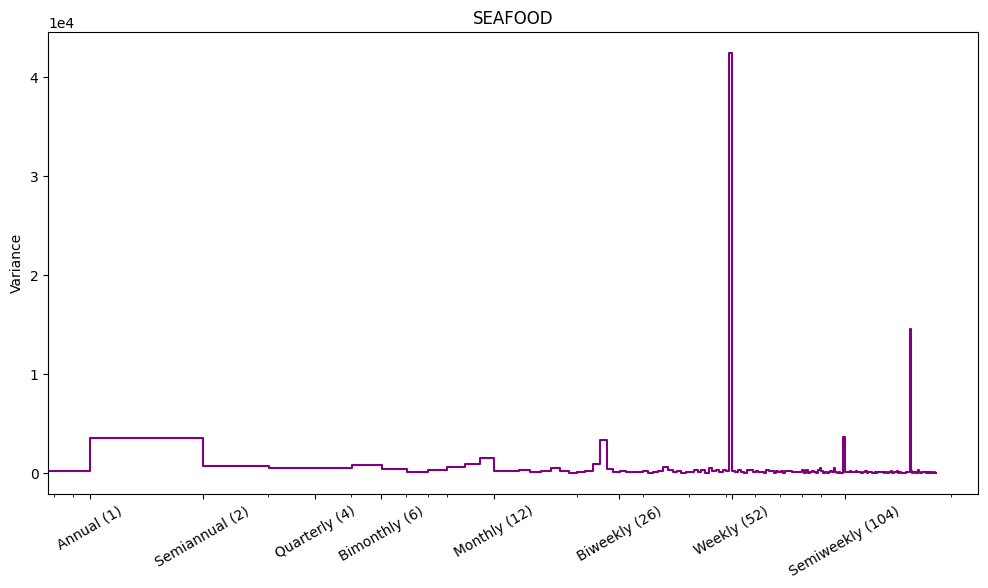

In [13]:

# let me run plot_periodogram for all unique family values in df.
# i will use the 2015 data for each family.

for family in family_sales:
    df_family_sales = family_sales[family]
    df_family_sales_2015 = df_family_sales[df_family_sales['date'].dt.year == 2015]
    df_family_sales_2015.set_index('date', inplace=True)
    plot_periodogram(df_family_sales_2015['sales'])
    plt.title(family)
    plt.show()
  


In [14]:

# okay so what I think now:
# I will make a one hot encoded feature for day of the week.
# For seasonality, I think it will be good to use 5 Fourier pairs. 
# I will do target encoding with temporal awareness for family (average sales for family in 
# that store cluster, for every day up until that day).)
# I will use store cluster for store_nbr's.
# I will make holiday_in_region as a binary feature for the day.
